# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
128320,1703817659999,0.000474,1m,2023-12-29 02:40:59.999,0.000514,-0.000041,0.004392
128321,1703817719999,0.000474,1m,2023-12-29 02:41:59.999,0.000515,-0.000041,-0.056085
128322,1703817779999,0.000474,1m,2023-12-29 02:42:59.999,0.000517,-0.000044,-0.372399
128323,1703817839999,0.000474,1m,2023-12-29 02:43:59.999,0.000517,-0.000044,-0.374169
128324,1703817899999,0.000474,1m,2023-12-29 02:44:59.999,0.000517,-0.000044,-0.376171
128325,1703817959999,0.000473,1m,2023-12-29 02:45:59.999,0.000517,-0.000044,-0.441476
128326,1703818019999,0.000473,1m,2023-12-29 02:46:59.999,0.000517,-0.000044,-0.425762
128327,1703818079999,0.000473,1m,2023-12-29 02:47:59.999,0.000517,-0.000044,-0.482393
128328,1703818139999,0.000473,1m,2023-12-29 02:48:59.999,0.000517,-0.000044,-0.511045
128329,1703818199999,0.000473,1m,2023-12-29 02:49:59.999,0.000517,-0.000044,-0.513895


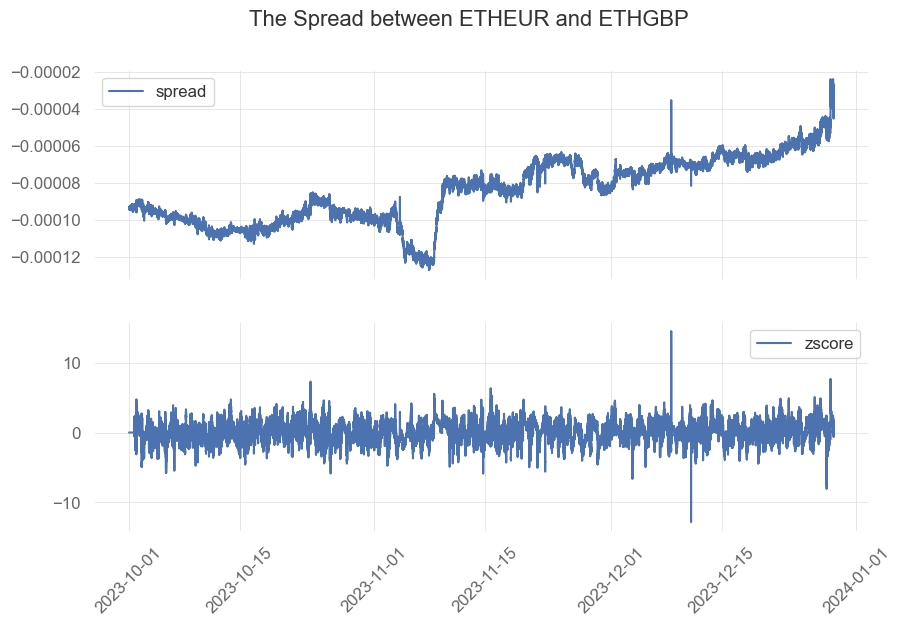

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 41040


## Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 14/41040 [00:00<05:12, 131.21it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:1.0, networth: 1.0


 10%|█         | 4119/41040 [00:43<06:42, 91.82it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 0, reward:0.0, networth: 1.0134


 20%|██        | 8229/41040 [01:21<05:02, 108.44it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.0, networth: 1.0191


 30%|███       | 12321/41040 [01:58<04:15, 112.25it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.0, networth: 1.0323


 40%|████      | 16441/41040 [02:35<03:31, 116.37it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.0407


 50%|█████     | 20535/41040 [03:11<03:07, 109.26it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:1.0, networth: 1.0662


 60%|██████    | 24647/41040 [03:46<02:20, 116.82it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.0887


 70%|███████   | 28747/41040 [04:23<01:49, 112.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:1.0, networth: 1.0973


 80%|████████  | 32846/41040 [04:59<01:11, 113.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:1.0, networth: 1.1095


 90%|█████████ | 36952/41040 [05:36<00:36, 113.44it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.114


100%|██████████| 41040/41040 [06:12<00:00, 110.19it/s]

Finished
networth: 1.1202895298017437


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 13/41040 [00:00<05:28, 124.91it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:1.0, networth: 1.0


 10%|█         | 4114/41040 [01:10<14:06, 43.64it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.0, networth: 1.0154


 20%|██        | 8229/41040 [01:52<04:40, 116.99it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.0, networth: 1.0187


 30%|███       | 12333/41040 [02:28<04:02, 118.32it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.0, networth: 1.0335


 40%|████      | 16428/41040 [03:04<03:36, 113.47it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.046


 50%|█████     | 20536/41040 [03:38<03:02, 112.64it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:1.0, networth: 1.0763


 60%|██████    | 24637/41040 [04:14<02:26, 111.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.0972


 70%|███████   | 28743/41040 [04:52<01:58, 103.78it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:1.0, networth: 1.1082


 80%|████████  | 32851/41040 [05:30<01:19, 103.45it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:1.0, networth: 1.1222


 90%|█████████ | 36947/41040 [06:08<00:41, 98.23it/s] 

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.13


100%|██████████| 41040/41040 [06:43<00:00, 101.83it/s]

Finished
networth: 1.133736037661777


In [15]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|          | 13/41040 [00:00<05:15, 129.99it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:1.0, networth: 1.0


 10%|█         | 4120/41040 [00:35<05:40, 108.56it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.0, networth: 0.9983


 20%|██        | 8221/41040 [01:09<04:32, 120.41it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:1.007, networth: 0.9986


 30%|███       | 12327/41040 [01:43<03:53, 123.22it/s]

signal: {'position': array(2, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:1.019, networth: 1.0024


 40%|████      | 16437/41040 [02:15<03:13, 127.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.0, networth: 1.0062


 50%|█████     | 20536/41040 [02:48<02:37, 130.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 2, reward:0.0, networth: 1.0087


 60%|██████    | 24643/41040 [03:21<02:14, 121.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.0, networth: 1.0085


 70%|███████   | 28746/41040 [03:53<01:39, 123.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 2, reward:0.0, networth: 1.0145


 80%|████████  | 32845/41040 [04:25<01:05, 124.22it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 2, reward:0.0, networth: 1.0181


 90%|█████████ | 36955/41040 [04:57<00:32, 125.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 1.0228


100%|██████████| 41040/41040 [05:29<00:00, 124.53it/s]

Finished
networth: 1.0223330760347158


## Also run randomly generated actions

In [16]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 15/41040 [00:00<04:52, 140.19it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 0, reward:0.0, networth: 1.0


 10%|█         | 4112/41040 [00:41<06:46, 90.89it/s] 

signal: {'position': 2, 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:1.008, networth: 1.0


 20%|██        | 8233/41040 [01:07<03:03, 178.58it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:0.992, networth: 0.9999


 30%|███       | 12336/41040 [01:30<02:38, 181.19it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.04332489])}, action: 2, reward:0.0, networth: 0.993


 40%|████      | 16455/41040 [01:53<02:14, 182.77it/s]

signal: {'position': 0, 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:1.023, networth: 0.9992


 50%|█████     | 20552/41040 [02:16<01:58, 173.51it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:1.0, networth: 0.9967


 60%|██████    | 24644/41040 [02:39<01:30, 181.13it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:1.01, networth: 0.9982


 70%|███████   | 28760/41040 [03:01<01:10, 175.22it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.68014561])}, action: 2, reward:0.0, networth: 0.9988


 80%|████████  | 32870/41040 [03:24<00:44, 184.77it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.60771416])}, action: 0, reward:0.0, networth: 0.9907


 90%|█████████ | 36970/41040 [03:47<00:22, 181.73it/s]

signal: {'position': 2, 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:1.0, networth: 0.9914


100%|██████████| 41040/41040 [04:10<00:00, 164.03it/s]

Finished
networth: 0.9866741398941177


### Analyze with Quanstats

In [17]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 03:00:59.999000', '1.133736037661777']
The ending capital of networth_dqn.csv is ['2023-11-30 03:00:59.999000', '1.0223330760347158']
The ending capital of networth_ppo.csv is ['2023-11-30 03:00:59.999000', '1.1202895298017437']
The best model is networth_a2c.csv


In [18]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 414%
Total orders count: 41039
Total long action: 9040
Total short action: 3918
Won orders count: 699
Lost orders count: 19
Win/Loss order ratio: 36.78947368421053
Max win: 0.00370011331934772
Max Loss: -0.0030707347462306522
Avg order pnl: 3.258754785978633e-06
Avg order pnl won: 0.0002016980864741416
Avg order pnl lost: -0.00038162762019199265


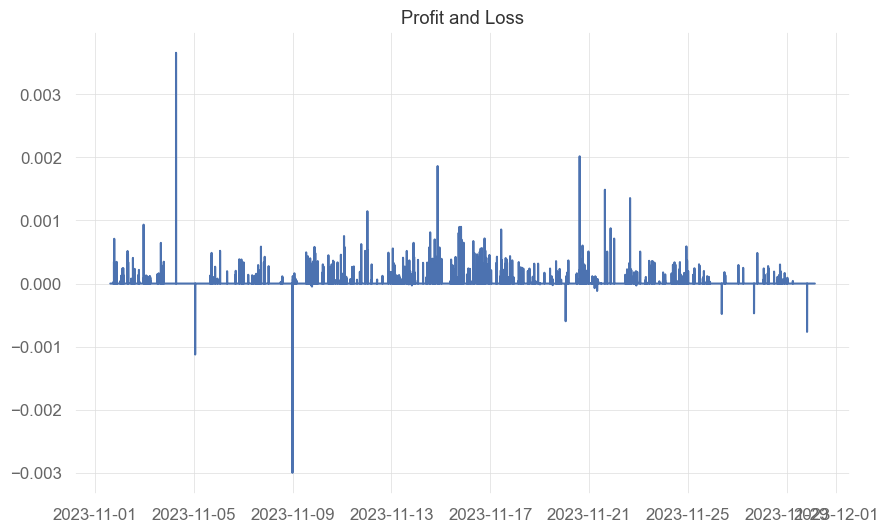

In [19]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-11-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             2.0%

Cumulative Return          13.37%
CAGR﹪                     209.46%

Sharpe                     1.12
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.11
Sortino                    2.88
Smart Sortino              2.86
Sortino/√2                 2.04
Smart Sortino/√2           2.03
Omega                      19.35

Max Drawdown               -0.3%
Longest DD Days            1
Volatility (ann.)          0.07%
Calmar                     698.27
Skew                       17.68
Kurtosis                   2109.38

Expected Daily %           0.0%
Expected Monthly %         13.37%
Expected Yearly %          13.37%
Kelly Criterion            92.32%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-08,2023-11-08,2023-11-09,1,-0.299971,-0.288143
2,2023-11-05,2023-11-05,2023-11-05,1,-0.112480,-0.109071
3,2023-11-29,2023-11-29,2023-11-30,1,-0.076577,NaN
4,2023-11-20,2023-11-20,2023-11-20,1,-0.059704,-0.048977
5,2023-11-26,2023-11-26,2023-11-27,1,-0.048230,-0.030179


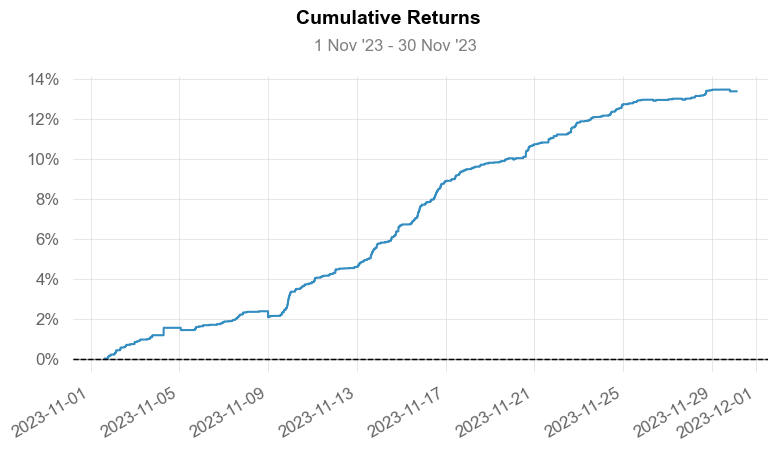

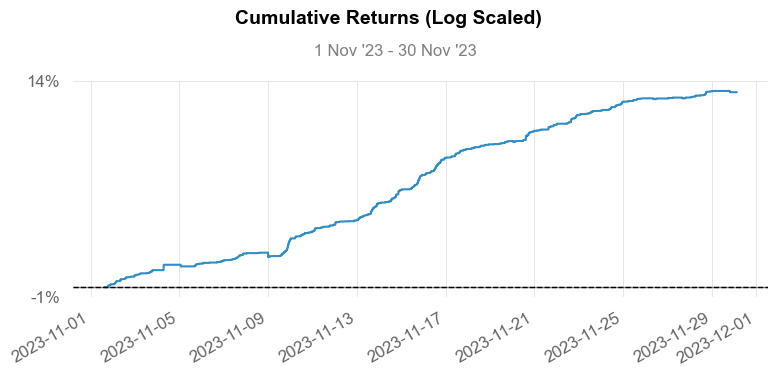

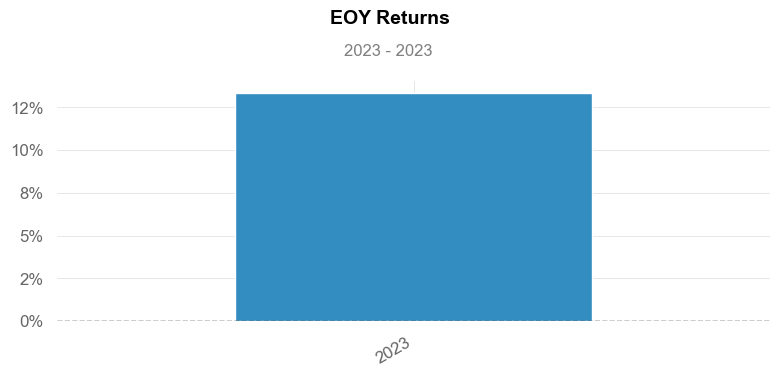

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


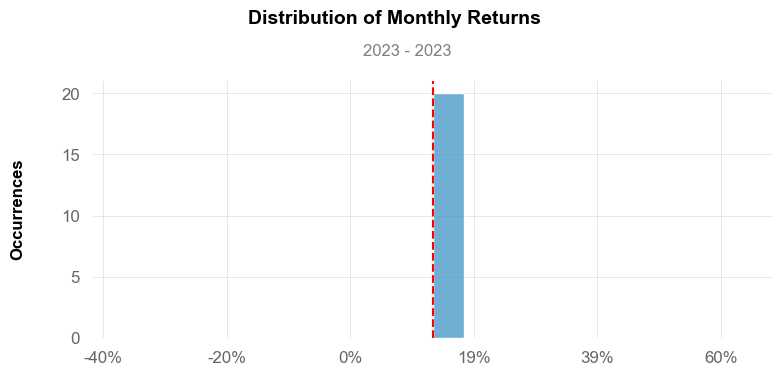

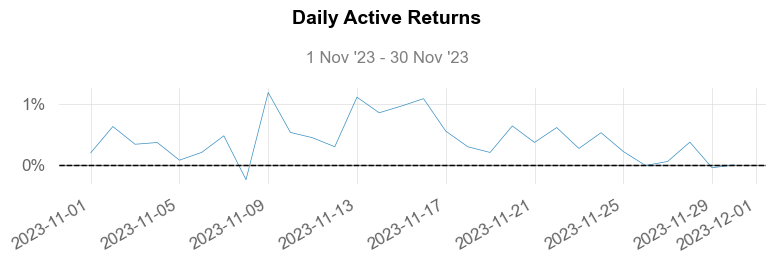

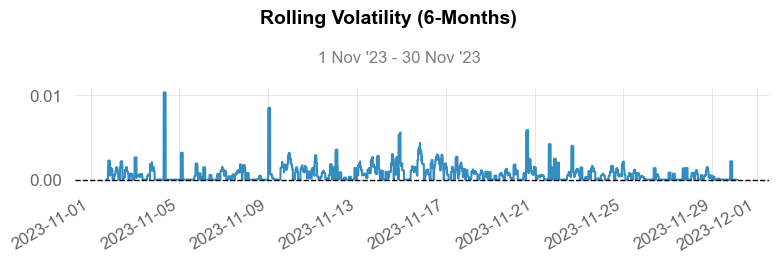

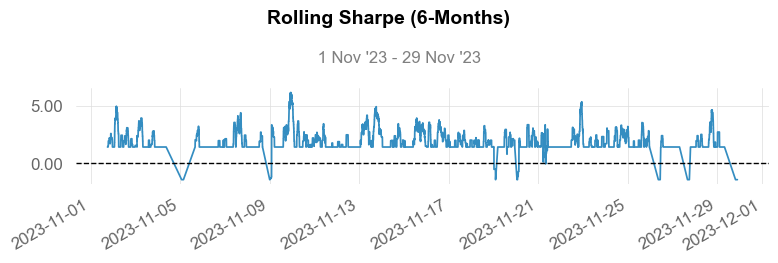

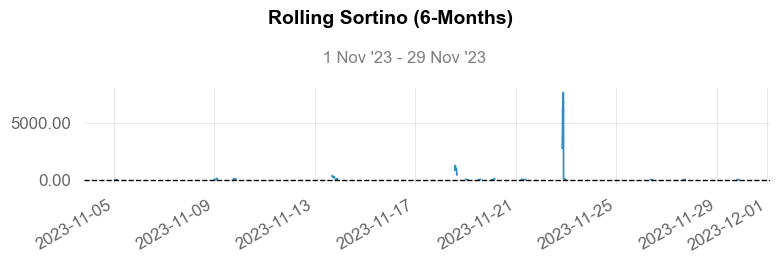

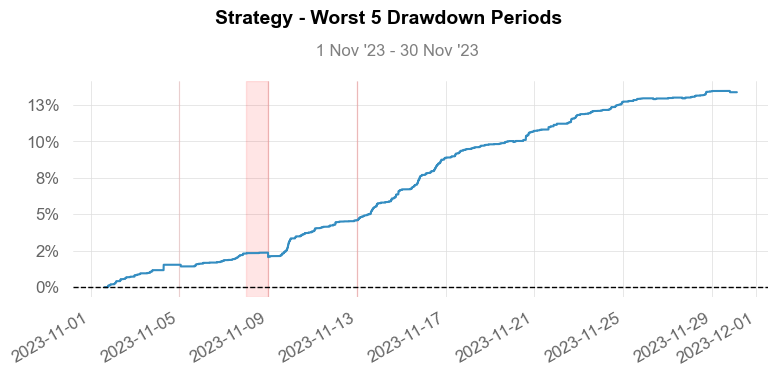

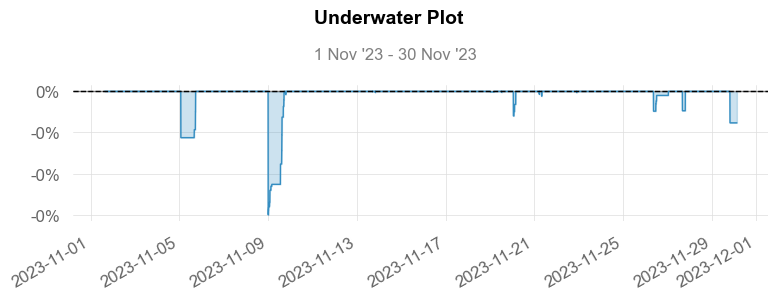

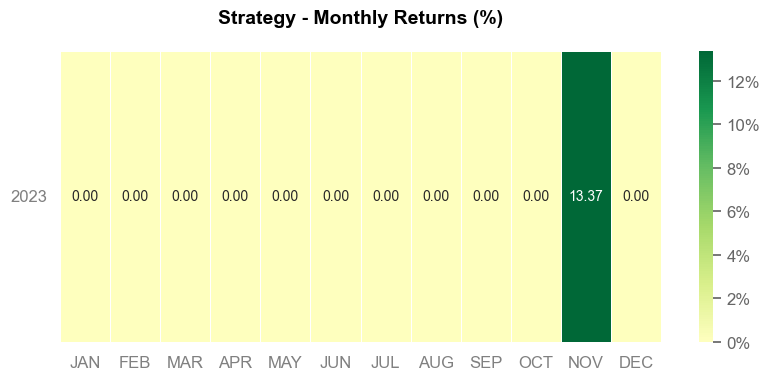

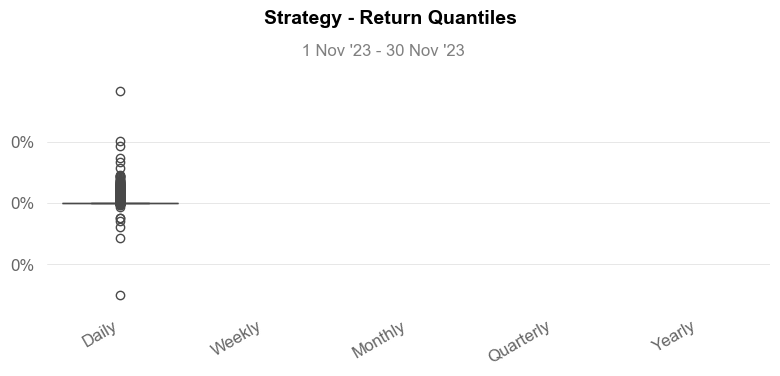

In [20]:
qs.reports.full(best_return['returns'])